Le code est ecrit a l'aide du chatgpt, stack overflow et geek for geeks

In [1]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
import cv2
import matplotlib.pyplot as plt
import mahotas 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from skimage.feature import graycomatrix, graycoprops



<h2>Defining descriptors

In [2]:
def extract_pixel_intensity(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    pixel_intensity = image_resized.mean(axis=(0, 1))  
    return pixel_intensity


In [4]:
def extract_sift(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    sift = cv2.SIFT_create()
    
    kp, des = sift.detectAndCompute(image_gray, None)
    
    if des is None:
        return np.zeros(128)
    
    return des.flatten()[:128]

In [6]:

def extract_hog(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3: 
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    # Extract HOG features
    hog_features, _ = hog(
        image_gray, 
        pixels_per_cell=(8, 8), 
        cells_per_block=(2, 2), 
        visualize=True
    )
    
    return hog_features


In [8]:

def extract_lbp(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2: 
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')
    
    lbp_hist = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))[0]
    
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    return lbp_hist


In [10]:

def extract_haralick(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    haralick_features = mahotas.features.haralick(image_gray).mean(axis=0)
    
    contrast, homogeneity = haralick_features[1], haralick_features[8]
    
    return np.array([contrast, homogeneity])


In [12]:
def extract_gabor(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    gabor_features = []
    for frequency in (0.1, 0.3, 0.5, 0.7, 1.0):  
        real, _ = gabor(image_gray, frequency=frequency)
        gabor_features.append(real.mean())
    
    return np.array(gabor_features)


In [14]:
from skimage.morphology import skeletonize

def skeleton_descriptor(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2: 
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    
    skeleton = skeletonize(image_gray > 128)
    
    skeleton_fraction = np.sum(skeleton) / skeleton.size
    
    return np.array([skeleton_fraction])


In [16]:
from skimage.feature import graycomatrix, graycoprops

def glcm_descriptor(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    glcm = graycomatrix(image_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    return np.array([contrast, homogeneity])


In [18]:
def extract_first_order_statistics(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2:  
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    mean_intensity = np.mean(image_gray)
    std_intensity = np.std(image_gray)
    
    return np.array([mean_intensity, std_intensity])


In [20]:
def extract_projection(image):
    image_resized = resize(image, (28, 28), anti_aliasing=True)
    
    if len(image_resized.shape) == 2: 
        image_gray = (image_resized * 255).astype(np.uint8)
    elif len(image_resized.shape) == 3:  
        image_gray = cv2.cvtColor((image_resized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError("Unexpected image shape: {}".format(image_resized.shape))
    
    horizontal_projection = np.sum(image_gray, axis=1)  # Sum over rows
    vertical_projection = np.sum(image_gray, axis=0)    # Sum over columns
    
    horizontal_projection = horizontal_projection / np.sum(horizontal_projection)
    vertical_projection = vertical_projection / np.sum(vertical_projection)
    
    return np.concatenate([horizontal_projection, vertical_projection])


<h3>Distance matrix dependinng on the descriptor

In [21]:
# def compute_distance_matrix(images, descriptor_function):
#     features = [descriptor_function(image) for image in images]  
#     distance_matrix = pairwise_distances(features)  
#     return distance_matrix

In [2]:
import torch
import numpy as np

def compute_distance_matrix(images, descriptor_function, feature_size=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    features = []
    for image in images:
        try:
            feature = descriptor_function(image)

            if isinstance(feature, np.float64) or np.isscalar(feature):
                feature = [feature]

            feature = np.array(feature)

            if feature.size < feature_size:
                feature = np.pad(feature, (0, feature_size - feature.size), mode='constant')
            elif feature.size > feature_size:
                feature = feature[:feature_size]

            features.append(feature)
        except Exception as e:
            print(f"Error processing image: {e}")
            features.append([0] * feature_size)

    features_tensor = torch.tensor(features, dtype=torch.float32, device=device)

    distance_matrix = torch.cdist(features_tensor, features_tensor, p=2)
    return distance_matrix


In [3]:
def display_distance_matrix(distance_matrix, title):
    if isinstance(distance_matrix, torch.Tensor):
        distance_matrix = distance_matrix.cpu().numpy()
    plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()


<h3>Puting the images in a list fpr readibility 

In [4]:
food_directory = 'archive/training/food'
non_food_directory = 'archive/training/non_food'

food_image_paths = [os.path.join(food_directory, filename) for filename in os.listdir(food_directory) if filename.endswith('.png') or filename.endswith('.jpg')]
food_images = [io.imread(image_path) for image_path in food_image_paths]

non_food_image_paths = [os.path.join(non_food_directory, filename) for filename in os.listdir(non_food_directory) if filename.endswith('.png') or filename.endswith('.jpg')]
non_food_images = [io.imread(image_path) for image_path in non_food_image_paths]

image_paths = food_image_paths + non_food_image_paths
images = food_images + non_food_images


<h2>Calculating the distance matrix for each descriptor

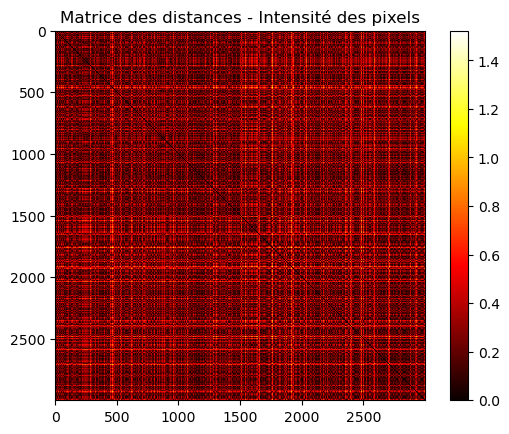

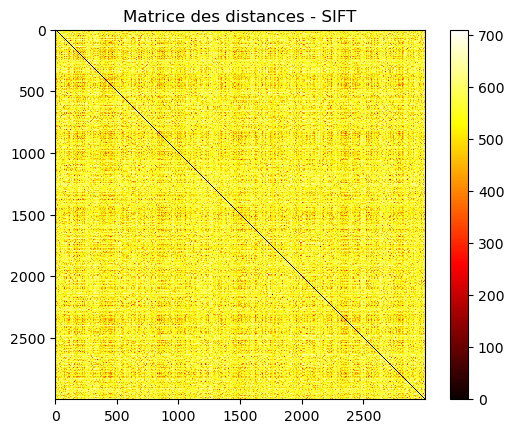

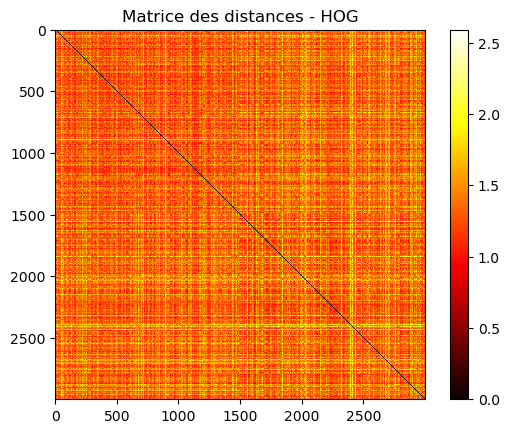

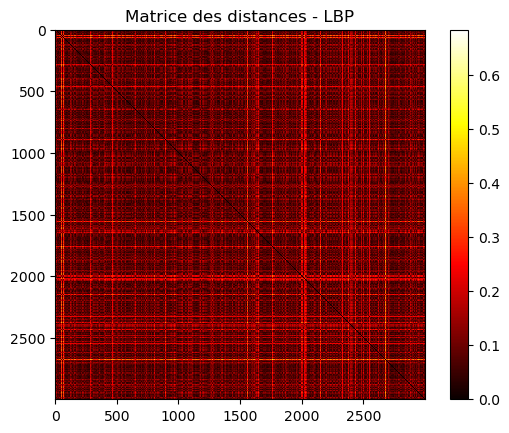

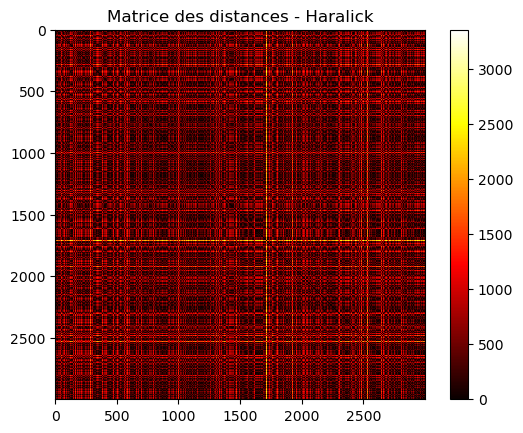

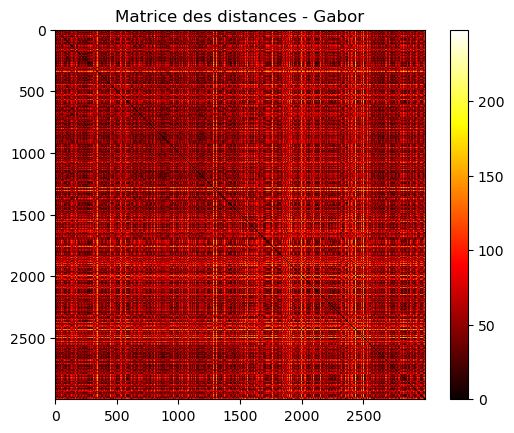

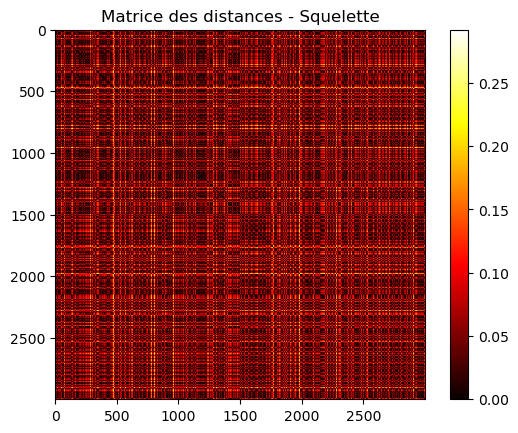

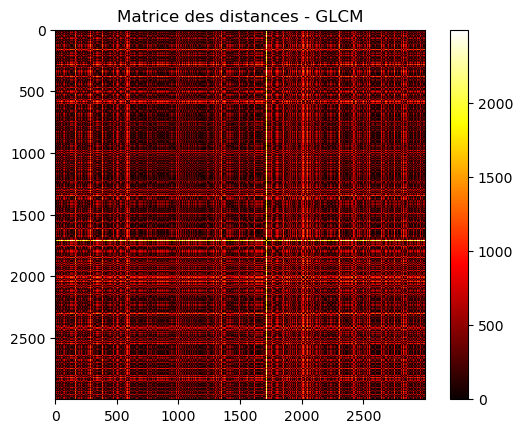

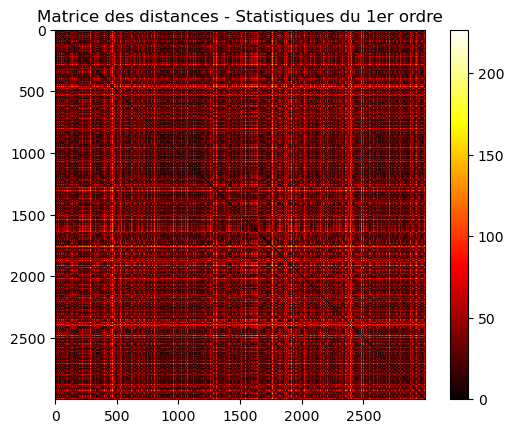

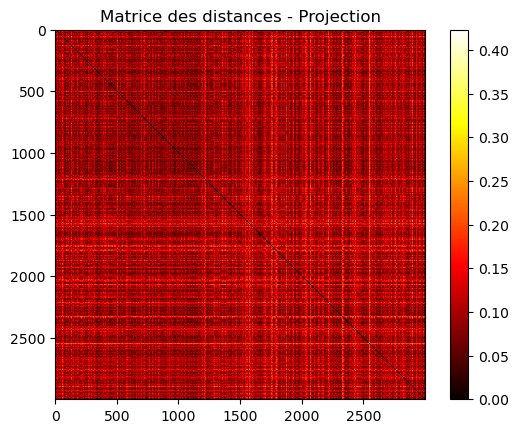

In [31]:
for descriptor_function, name in zip([extract_pixel_intensity, extract_sift, extract_hog, extract_lbp, extract_haralick, extract_gabor,skeleton_descriptor,glcm_descriptor,extract_first_order_statistics,extract_projection],
                                      ['Intensité des pixels', 'SIFT', 'HOG', 'LBP', 'Haralick', 'Gabor','Squelette','GLCM','Statistiques du 1er ordre','Projection']):
    distance_matrix = compute_distance_matrix(images, descriptor_function)
    display_distance_matrix(distance_matrix, f"Matrice des distances - {name}")


<h2>We try with merging these descriptors

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Fonction d'extraction de toutes les caractéristiques
def extract_features(image):
    pixel_intensity = extract_pixel_intensity(image)  
    lbp_hist = extract_lbp(image)  
    haralick_features = extract_haralick(image) 
    gabor_features = extract_gabor(image)  
    skeleton_features = skeleton_descriptor(image) 
    glcm_features = glcm_descriptor(image) 
    first_order_features = extract_first_order_statistics(image)  
    projecions = extract_projection(image)
    features = np.hstack([pixel_intensity, lbp_hist, haralick_features, gabor_features, skeleton_features, glcm_features, first_order_features, projecions])
    # scaler = MinMaxScaler()
    # features_normalized = scaler.fit_transform(features.reshape(-1, 1)).flatten()
    return features


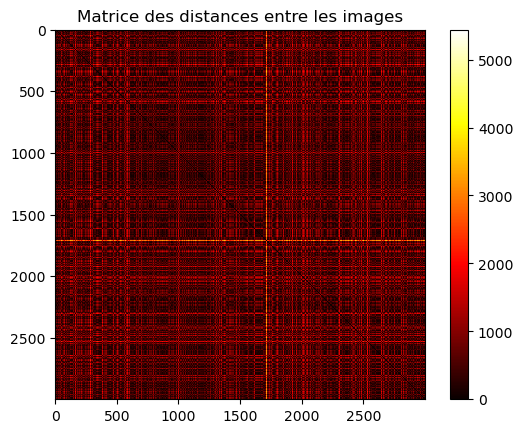

In [33]:
distance_matrix = compute_distance_matrix(images, extract_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")

In [34]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import numpy as np
import cv2

def extract_resnet50_features(img):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a pretrained ResNet-50 model
    model = resnet50(pretrained=True)
    model = model.eval()  # Set the model to evaluation mode
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification head
    model = model.to(device)  # Move the model to the GPU/CPU

    # Define preprocessing transforms
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # Convert NumPy array to PIL image
        transforms.Resize((224, 224)),  # Resize image to 224x224
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Preprocess the image
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    img_tensor = img_tensor.to(device)  # Move the tensor to the GPU/CPU

    # Extract features
    with torch.no_grad():
        features = model(img_tensor)

    # Flatten the features into a 1D array
    feat = features.view(-1).cpu().numpy()  # Move back to CPU before converting to NumPy
    return feat


/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


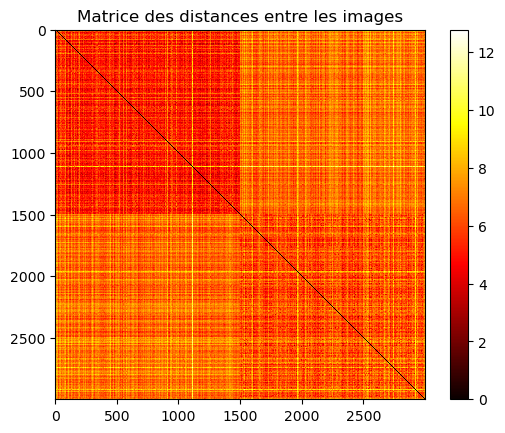

In [35]:
distance_matrix = compute_distance_matrix(images, extract_resnet50_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [37]:
from torchvision.models import densenet121

def extract_densenet121_features(img):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a pretrained DenseNet-121 model
    model = densenet121(pretrained=True)
    model = model.eval()  # Set the model to evaluation mode
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the classification head
    model = model.to(device)  # Move the model to the GPU/CPU

    # Define preprocessing transforms
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # Convert NumPy array to PIL image
        transforms.Resize((224, 224)),  # Resize image to 224x224
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Preprocess the image
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    img_tensor = img_tensor.to(device)  # Move the tensor to the GPU/CPU

    # Extract features
    with torch.no_grad():
        features = model(img_tensor)

    # Flatten the features into a 1D array
    feat = features.view(-1).cpu().numpy()  # Move back to CPU before converting to NumPy
    return feat

/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


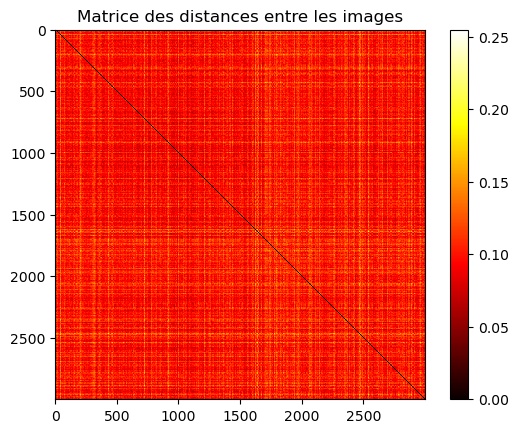

In [38]:
distance_matrix = compute_distance_matrix(images, extract_densenet121_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [5]:
import torch
from transformers import ViTModel, ViTFeatureExtractor
import numpy as np
import cv2

def extract_vit_features(img):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pretrained ViT model
    model = ViTModel.from_pretrained("google/vit-base-patch16-224")
    model = model.eval()  # Set the model to evaluation mode
    model = model.to(device)  # Move the model to the GPU/CPU

    # Load the feature extractor
    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

    # Preprocess the image using the feature extractor
    inputs = feature_extractor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU/CPU

    # Extract features
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the last hidden state (sequence of patch embeddings)
    last_hidden_state = outputs.last_hidden_state

    # Pool the features by averaging over the sequence dimension
    features = last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy()
    return features


2025-02-23 21:44:12.842622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 21:44:12.975837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740343453.035026    4941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740343453.053882    4941 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 21:44:13.182762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly i

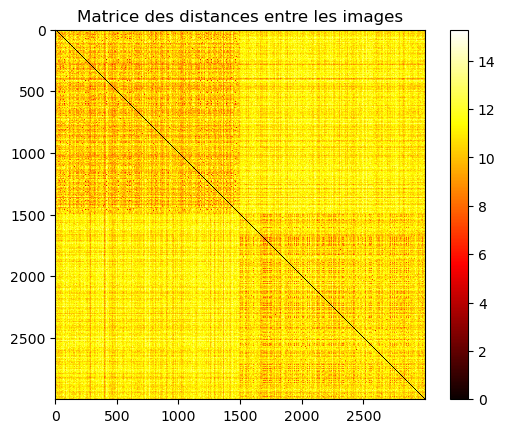

In [6]:
distance_matrix = compute_distance_matrix(images, extract_vit_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [5]:
import torch
from transformers import CLIPModel, CLIPProcessor
import numpy as np

def extract_clip_features(img):
    # Vérifiez si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Chargez le modèle CLIP pré-entraîné
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
    model.eval()  # Passez le modèle en mode évaluation
    model.to(device)  # Déplacez le modèle vers le GPU/CPU

    # Chargez le processeur associé
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

    # Prétraitez l'image en utilisant le processeur
    inputs = processor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Déplacez les entrées vers le GPU/CPU

    # Extrayez les caractéristiques
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)

    # Normalisez les caractéristiques
    features = outputs / outputs.norm(p=2, dim=-1, keepdim=True)

    # Convertissez en tableau NumPy
    features = features.squeeze(0).cpu().numpy()
    return features


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


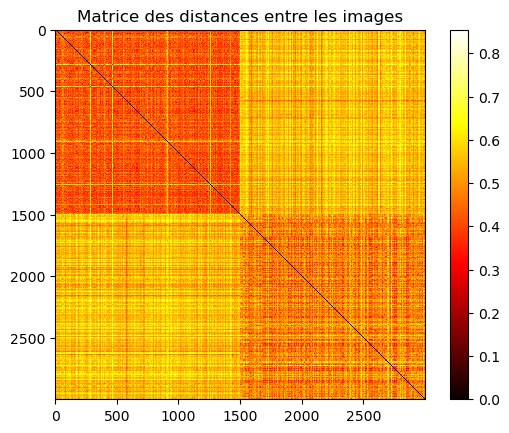

In [18]:
distance_matrix = compute_distance_matrix(images, extract_clip_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [5]:
import torch
from transformers import CLIPModel, CLIPProcessor
import numpy as np

def extract_openclip_features(img):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a more powerful OpenCLIP model
    model = CLIPModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the GPU/CPU

    # Load the associated processor
    processor = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

    # Preprocess the image using the processor
    inputs = processor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU/CPU

    # Extract features
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)

    # Normalize the features
    features = outputs / outputs.norm(p=2, dim=-1, keepdim=True)

    # Convert to a NumPy array
    features = features.squeeze(0).cpu().numpy()
    return features


config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

2025-01-25 20:01:03.260787: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-25 20:01:03.388910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737831663.440810   19361 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737831663.456992   19361 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 20:01:03.583152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


/tmp/ipykernel_19361/169261835.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


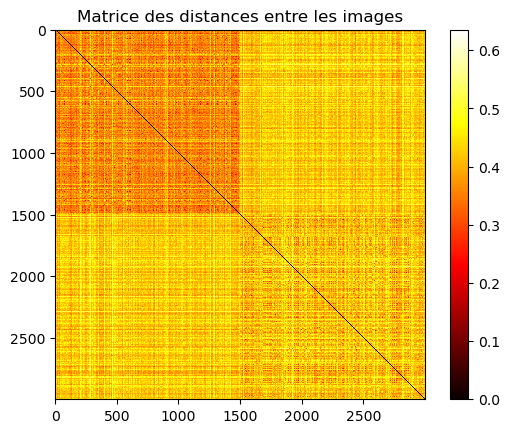

In [6]:
distance_matrix = compute_distance_matrix(images, extract_openclip_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [8]:
from transformers import Dinov2Model, AutoImageProcessor
import torch
import numpy as np

def extract_dinov2_features(img):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the pretrained DINOv2 model
    model = Dinov2Model.from_pretrained("facebook/dinov2-large")
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move the model to the GPU/CPU

    # Load the image processor
    processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")

    # Preprocess the image
    inputs = processor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU/CPU

    # Extract features
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the pooled output
    pooled_features = outputs.pooler_output

    # Convert to NumPy
    features = pooled_features.squeeze(0).cpu().numpy()
    return features


config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


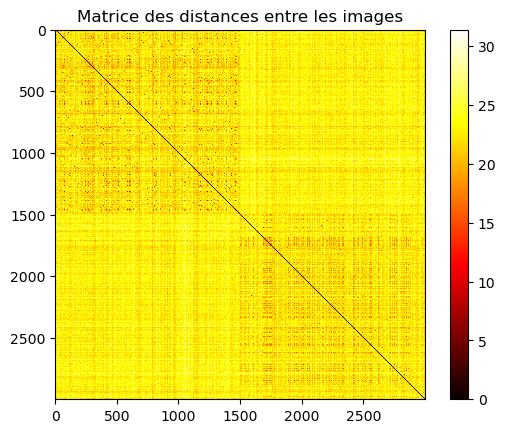

In [9]:
distance_matrix = compute_distance_matrix(images, extract_dinov2_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [14]:
from transformers import AutoFeatureExtractor, SwinModel
import torch

def extract_swin_features(img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224").to(device)
    feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

    inputs = feature_extractor(images=img, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    features = outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy()  # Average pooling
    return features


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

/home/benk/anaconda3/envs/ML/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


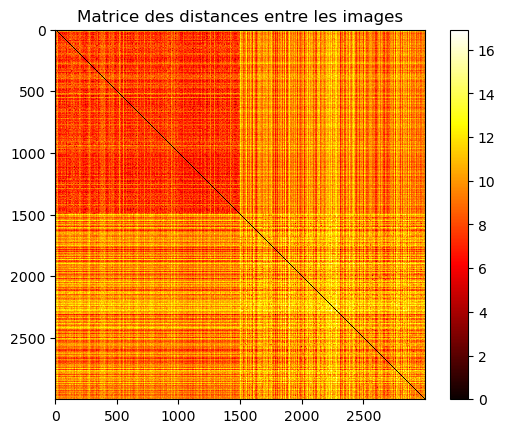

In [15]:
distance_matrix = compute_distance_matrix(images, extract_swin_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [6]:
import torch
from transformers import CLIPModel, CLIPProcessor
import numpy as np

def extract_clipLarge_features(img):
    # Vérifiez si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Chargez le modèle CLIP pré-entraîné
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")    
    model.eval()  # Passez le modèle en mode évaluation
    model.to(device)  # Déplacez le modèle vers le GPU/CPU

    # Chargez le processeur associé
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

    # Prétraitez l'image en utilisant le processeur
    inputs = processor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Déplacez les entrées vers le GPU/CPU

    # Extrayez les caractéristiques
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)

    # Normalisez les caractéristiques
    features = outputs / outputs.norm(p=2, dim=-1, keepdim=True)

    # Convertissez en tableau NumPy
    features = features.squeeze(0).cpu().numpy()
    return features


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

2025-01-29 00:04:59.508548: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 00:04:59.635806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738105499.687861   15493 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738105499.707571   15493 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 00:04:59.834223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


/tmp/ipykernel_15493/169261835.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


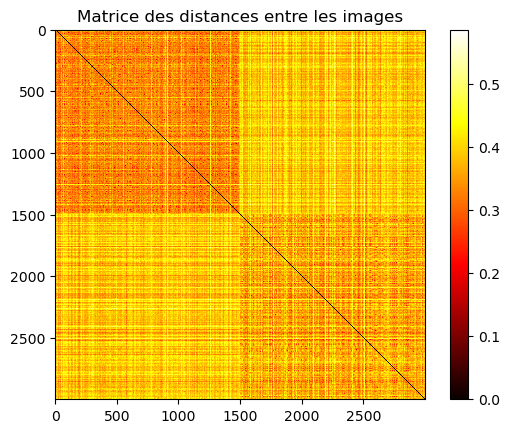

In [6]:
distance_matrix = compute_distance_matrix(images, extract_clipLarge_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [12]:
def ensemble_descriptors_concat(img):
    clip_features = extract_clip_features(img)
    clipLarge_features = extract_clipLarge_features(img)
    vit_features = extract_vit_features(img)

    # Concatenate features
    combined_features = np.concatenate((clip_features,clipLarge_features ,vit_features, ), axis=0)
    return combined_features

In [ ]:
distance_matrix = compute_distance_matrix(images, ensemble_descriptors_concat)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [15]:
def ensemble_descriptors_avg(img):
    # Extract features from multiple models
    clip_features = extract_clip_features(img)
    print("clip done !")
    clipLarge_features = extract_clipLarge_features(img)
    print("clipLarge done !")    
    # vit_features = extract_vit_features(img)
    # print("vit done !")    

    # Average features
    combined_features = (clip_features+clipLarge_features) / 2
    return combined_features

In [ ]:
distance_matrix = compute_distance_matrix(images, ensemble_descriptors_avg)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


In [ ]:
distance_matrix1 = compute_distance_matrix(images, extract_clip_features)
distance_matrix2 = compute_distance_matrix(images, extract_clipLarge_features)
distance_matrix3 = (distance_matrix2 + distance_matrix1) / 2
display_distance_matrix(distance_matrix3, "Matrice des distances entre les images")

2025-02-23 23:57:43.635102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 23:57:43.760102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740351463.813413   51701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740351463.830080   51701 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 23:57:43.951785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Error processing image: (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: c680cd5c-bfed-4442-b63d-fbe3a7b1652c)')
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensio

/tmp/ipykernel_51701/169261835.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


<h2>Met tjr les imports en haut

In [1]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
import cv2
import matplotlib.pyplot as plt
import mahotas 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from skimage.feature import graycomatrix, graycoprops
import torch



<h3>la fonction qui va calculer la matrice de distance

In [2]:

def compute_distance_matrix(images, descriptor_function, feature_size=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    features = []
    for image in images:
        try:
            feature = descriptor_function(image)

            if isinstance(feature, np.float64) or np.isscalar(feature):
                feature = [feature]

            feature = np.array(feature)

            if feature.size < feature_size:
                feature = np.pad(feature, (0, feature_size - feature.size), mode='constant')
            elif feature.size > feature_size:
                feature = feature[:feature_size]

            features.append(feature)
        except Exception as e:
            print(f"Error processing image: {e}")
            features.append([0] * feature_size)

    features_tensor = torch.tensor(features, dtype=torch.float32, device=device)

    distance_matrix = torch.cdist(features_tensor, features_tensor, p=2)
    return distance_matrix


<h3>l'affichage de la matrice

In [3]:
def display_distance_matrix(distance_matrix, title):
    if isinstance(distance_matrix, torch.Tensor):
        distance_matrix = distance_matrix.cpu().numpy()
    plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()


<h3>Importer les image

In [4]:
food_directory = 'archive/training/food'
non_food_directory = 'archive/training/non_food'

food_image_paths = [os.path.join(food_directory, filename) for filename in os.listdir(food_directory) if filename.endswith('.png') or filename.endswith('.jpg')]
food_images = [io.imread(image_path) for image_path in food_image_paths]

non_food_image_paths = [os.path.join(non_food_directory, filename) for filename in os.listdir(non_food_directory) if filename.endswith('.png') or filename.endswith('.jpg')]
non_food_images = [io.imread(image_path) for image_path in non_food_image_paths]

image_paths = food_image_paths + non_food_image_paths
images = food_images + non_food_images


<h2>VOICI LA SQUELETTE DU CODE (peut etre modifiee)

In [7]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import timm
from transformers import ViTImageProcessor, ViTModel


def extract_inceptionV3_features(img):
    # Vérifie si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charge InceptionV3 pré-entraîné, en mode extraction de features
    model = timm.create_model('inception_v3', pretrained=True, features_only=True)
    model = model.eval().to(device)  # Mode évaluation et envoi sur GPU/CPU

    # Préprocessing adapté à InceptionV3
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((299, 299)),  # InceptionV3 attend une entrée de 299x299
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
    ])

    # Préparation de l'image
    img_tensor = preprocess(img).unsqueeze(0).to(device)  # Ajoute une dimension batch et envoie sur GPU/CPU

    # Extraction des features
    with torch.no_grad():
        features = model(img_tensor)[-1]  # On prend la dernière couche de features

    # Mise à plat des features pour obtenir un vecteur 1D
    feat = features.view(-1).cpu().numpy()  
    return feat

# Note : Pour un model plus grand, on peut remplacer "efficientnet_b0" par "efficientnet_b4"
def extract_efficientnet_features(img):
    # Vérifie si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charge un modèle EfficientNet pré-entraîné
    model = timm.create_model('efficientnet_b0', pretrained=True)
    model = model.eval()  # Mode évaluation
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Supprime la couche de classification
    model = model.to(device)  # Envoie le modèle sur GPU/CPU

    # Préprocessing de l'image adapté à EfficientNet
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((224, 224)),  # EfficientNet attend une entrée de 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
    ])

    # Préparation de l'image
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Ajoute une dimension batch
    img_tensor = img_tensor.to(device)  # Envoie l'image sur GPU/CPU

    # Extraction des features
    with torch.no_grad():
        features = model(img_tensor)

    # Mise à plat des features pour obtenir un vecteur 1D
    feat = features.view(-1).cpu().numpy()  
    return feat

# Note : on peut aussi tester avec "vit-large-patch32-384"
def extract_vit_features(img):
    # Vérifie si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charge le modèle ViT sans pooling + image processor
    model_name = "google/vit-base-patch16-224"
    processor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTModel.from_pretrained(model_name, add_pooling_layer=False).to(device)
    model.eval()  # Met en mode évaluation

    # Prétraitement de l’image avec ViTImageProcessor
    img_tensor = processor(images=img, return_tensors="pt")["pixel_values"].to(device)

    # Extraction des features
    with torch.no_grad():
        outputs = model(img_tensor)
        features = outputs.last_hidden_state  # Récupère les features de la dernière couche

    # Mise à plat des features en un vecteur 1D
    feat = features.view(-1).cpu().numpy()
    return feat

def extract_resnet101_features(img):
    # Vérifie si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charge ResNet101 pré-entraîné
    model = models.resnet101(pretrained=True)
    model.fc = torch.nn.Identity()  # Supprime la dernière couche de classification
    model = model.eval().to(device)  # Mode évaluation et envoi sur GPU/CPU

    # Préprocessing de l'image adapté à ResNet
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((224, 224)),  # ResNet attend une entrée de 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
    ])

    # Préparation de l'image
    img_tensor = preprocess(img).unsqueeze(0).to(device)  # Ajoute une dimension batch et envoie sur GPU/CPU

    # Extraction des features
    with torch.no_grad():
        features = model(img_tensor)

    # Mise à plat des features en un vecteur 1D
    feat = features.view(-1).cpu().numpy()
    return feat

C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Antoine BOURGEOIS\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(mess

Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


C:\Users\Antoine BOURGEOIS\AppData\Local\Temp\ipykernel_1596\2288914671.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


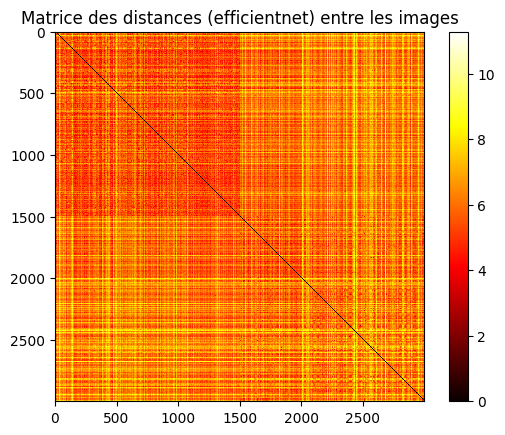

In [7]:
distance_matrix = compute_distance_matrix(images, extract_efficientnet_features)

display_distance_matrix(distance_matrix, "Matrice des distances (efficientnet) entre les images")

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


C:\Users\Antoine BOURGEOIS\AppData\Local\Temp\ipykernel_5232\2288914671.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


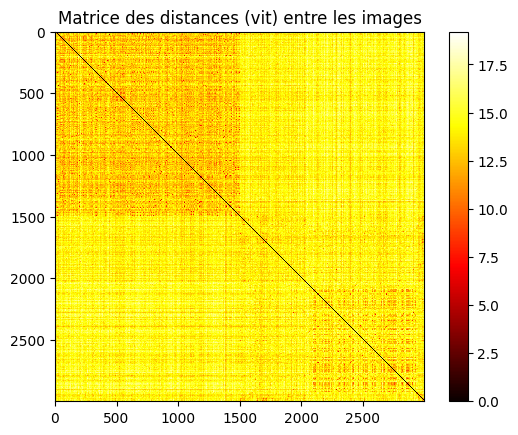

In [8]:
distance_matrix = compute_distance_matrix(images, extract_vit_features)

display_distance_matrix(distance_matrix, "Matrice des distances (vit) entre les images")

C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Antoine BOURGEOIS/.cache\torch\hub\checkpoints\resnet101-63fe2227.p

Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


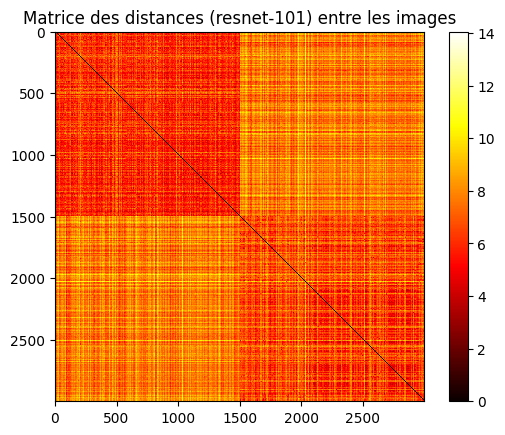

In [9]:
distance_matrix = compute_distance_matrix(images, extract_resnet101_features)

display_distance_matrix(distance_matrix, "Matrice des distances (resnet-101) entre les images")

C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Antoine BOURGEOIS\.cache\huggingface\hub\models--timm--inception_v3.tv_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message

Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


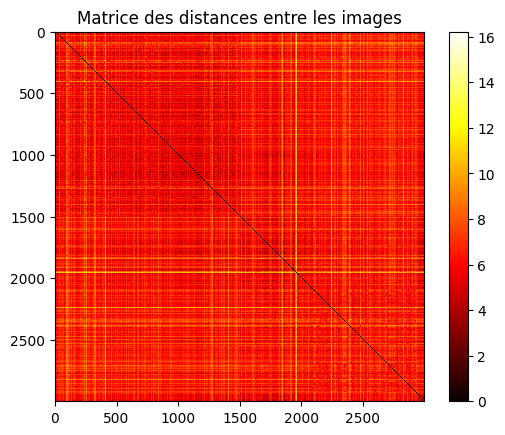

In [22]:
distance_matrix = compute_distance_matrix(images, extract_inceptionV3_features)

display_distance_matrix(distance_matrix, "Matrice des distances (inceptionV3) entre les images")

<H3>VOICI UN EXEMPLE POUR T'AIDER

In [18]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import numpy as np
import cv2

def extract_resnet50_features(img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a pretrained ResNet-50 model
    model = resnet50(pretrained=True)
    model = model.eval()  
    model = torch.nn.Sequential(*list(model.children())[:-1]) 
    model = model.to(device)  

    preprocess = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])

    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  
    img_tensor = img_tensor.to(device)  

    with torch.no_grad():
        features = model(img_tensor)

    feat = features.view(-1).cpu().numpy()  
    return feat


C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Antoine BOURGEOIS/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
1

Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


C:\Users\Antoine BOURGEOIS\AppData\Local\Temp\ipykernel_824\2288914671.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


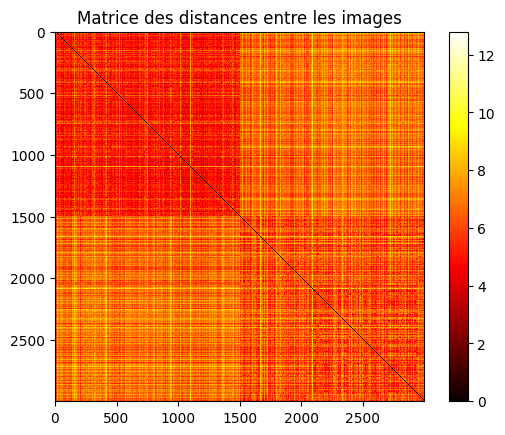

In [19]:
distance_matrix = compute_distance_matrix(images, extract_resnet50_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


<h2> MAINTENANT A TOI DE JOUER</h2>
<h4>Tu dois chercher des models du computer vision ou deep learning qui sont deja pre entrainer, cette squelette peut ne pas marcher avec tout les models, si tu devras modifier le code d'un model ce n'est pas un probleme, tu peut jouer avec les paramettres pour auguementer la performence, tu dois savoir que chaque model a ces paramettres donc pas forcement de mettre les meme pour tt le monde.</h4>
<h4>les dfficultes que tu vas rencontrer sont de trouver d'abord des models, apres de choisir les bon paramettres, et enfin c'est que a chaque fois tu execute ca va prendre beacoups de temps</h4>
<h4>make sure to not reuse the same models that i have already used! 